###Import Library Dan Load Dataset serta menampilkan statistik awal

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
from datetime import datetime
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from scipy import stats

from sklearn.model_selection import cross_val_score, KFold
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor

data_scraping = pd.read_csv("/content/drive/MyDrive/datasource/The_New_Hotel_Scraping.csv")

# Menampilkan kedua dataset awal
print(data_scraping.head())

# Mendapatkan dimensi dataframe
jumlah_baris, jumlah_kolom = data_scraping.shape

# Menampilkan jumlah data
print(f"Jumlah data: {jumlah_baris}")

  web-scraper-order                              web-scraper-start-url  \
0      1742910122-1  https://www.traveloka.com/id-id/hotel/indonesi...   
1      1742910122-2  https://www.traveloka.com/id-id/hotel/indonesi...   
2      1742910122-3  https://www.traveloka.com/id-id/hotel/indonesi...   
3      1742910122-4  https://www.traveloka.com/id-id/hotel/indonesi...   
4      1742910122-5  https://www.traveloka.com/id-id/hotel/indonesi...   

                                          nama_hotel  harga_permalam  \
0  Modern and Tidy Studio at Barsa City Apartment...          514125   
1                 RedDoorz @ Demangan Sari Residence          500000   
2                                Omasage Guest House          500000   
3  RedDoorz Syariah Near Universitas Pgri Yogyakarta          500000   
4                                  Emdi House Timoho          500000   

    type_hotal                    lokasi  rate rate_category hotel_segmen  \
0    Apartemen         Depok, Yogyakarta   8.

web-scraper-order           0
web-scraper-start-url       0
nama_hotel                  0
harga_permalam              0
type_hotal                  0
lokasi                      0
rate                        0
rate_category            4715
hotel_segmen             9629
periode                     0
total_review_visitor        0
dtype: int64


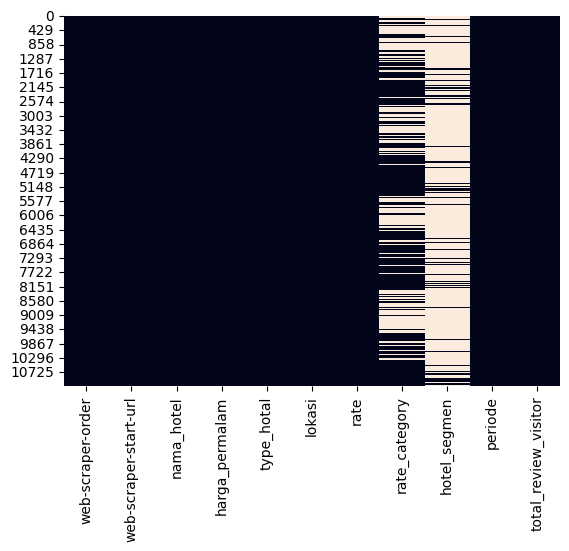

In [ ]:
# Check for missing values
print(data_scraping.isnull().sum())

# Visualize missing values
sns.heatmap(data_scraping.isnull(), cbar=False)
plt.show()

###Pre-Processing###

In [ ]:
#Menghapus kolom tidak relevan
data_scraping.drop(columns=["web-scraper-order", "web-scraper-start-url", "rate_category", "hotel_segmen"], errors="ignore", inplace=True)
print("\n Setelah drop kolom:")
print(data_scraping.head())


 Setelah drop kolom:
                                          nama_hotel  harga_permalam  \
0  Modern and Tidy Studio at Barsa City Apartment...          514125   
1                 RedDoorz @ Demangan Sari Residence          500000   
2                                Omasage Guest House          500000   
3  RedDoorz Syariah Near Universitas Pgri Yogyakarta          500000   
4                                  Emdi House Timoho          500000   

    type_hotal                    lokasi  rate      periode  \
0    Apartemen         Depok, Yogyakarta   8.5  26-29 Maret   
1        Hotel         Depok, Yogyakarta   7.9  26-29 Maret   
2      Lainnya  Gondokusuman, Yogyakarta   7.7  26-29 Maret   
3  Guest House    Wirobrajan, Yogyakarta   8.6  26-29 Maret   
4      Lainnya    Umbulharjo, Yogyakarta   8.1  26-29 Maret   

   total_review_visitor  
0                 105.0  
1                 465.0  
2                  52.0  
3                 120.0  
4                  96.0  


In [ ]:
data_scraping_no_duplicates = data_scraping.T.drop_duplicates().T

# Atau jika ingin tahu kolom apa saja yang diduplikasi
duplicated_cols = data_scraping.T.duplicated()
print("Kolom yang diduplikasi:", data_scraping.columns[duplicated_cols].tolist())

Kolom yang diduplikasi: []


In [ ]:
data_scraping.groupby('type_hotal').nama_hotel.count()

,nama_hotel
type_hotal,
Apartemen,1399
B&B,109
Camping,18
Guest House,1229
Homestay,1457
Hostel,565
Hotel,3942
Hotel Kapsul,40
Lainnya,675


In [ ]:
data_set = data_scraping.type_hotal.values
data_set = list(data_set)
data_set = ' '.join(data_set)

In [ ]:
#here we'll output the ten most common words in the Type column
from collections import Counter
split_str = data_set.split()

Counter = Counter(split_str)

common = Counter.most_common(10)
print(common)

[('Hotel', 3982), ('Homestay', 1457), ('Apartemen', 1399), ('Guest', 1229), ('House', 1229), ('Vila', 967), ('Lainnya', 675), ('Rumah', 646), ('Hostel', 565), ('B&B', 109)]


In [ ]:
#We can get a list of columns to add to our dataset and make one hot vectors for the types
tipe_hotel = []
for tup in common:
    tipe_hotel.append(tup[0].lower())

print(tipe_hotel)

['hotel', 'homestay', 'apartemen', 'guest', 'house', 'vila', 'lainnya', 'rumah', 'hostel', 'b&b']


In [ ]:
from sklearn.feature_extraction.text import CountVectorizer
pattern = "(?u)\\b[\\w&-]+\\b"
cv = CountVectorizer(vocabulary=tipe_hotel, token_pattern=pattern)

one_hot = pd.DataFrame(cv.fit_transform(data_scraping['type_hotal']).todense(),
                   data_scraping.index,
                    cv.get_feature_names_out())

one_hot

,hotel,homestay,apartemen,guest,house,vila,lainnya,rumah,hostel,b&b
0,0,0,1,0,0,0,0,0,0,0
1,1,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,1,0,0,0
3,0,0,0,1,1,0,0,0,0,0
4,0,0,0,0,0,0,1,0,0,0
...,...,...,...,...,...,...,...,...,...,...
11129,0,0,0,0,0,0,0,0,0,0
11130,1,0,0,0,0,0,0,0,0,0
11131,1,0,0,0,0,0,0,0,0,0
11132,1,0,0,0,0,0,0,0,0,0


In [ ]:
one_hot[['house','guest']].describe()

,house,guest
count,11134.000000,11134.000000
mean,0.110383,0.110383
std,0.313380,0.313380
min,0.000000,0.000000
25%,0.000000,0.000000
50%,0.000000,0.000000
75%,0.000000,0.000000
max,1.000000,1.000000


In [ ]:
one_hot = pd.DataFrame(cv.fit_transform(data_scraping['type_hotal']).todense(),
                   data_scraping.index,
                    cv.get_feature_names_out())

one_hot = one_hot.drop('guest', axis=1)
one_hot = one_hot.rename(columns={'house': 'guest-house'})
one_hot

,hotel,homestay,apartemen,guest-house,vila,lainnya,rumah,hostel,b&b
0,0,0,1,0,0,0,0,0,0
1,1,0,0,0,0,0,0,0,0
2,0,0,0,0,0,1,0,0,0
3,0,0,0,1,0,0,0,0,0
4,0,0,0,0,0,1,0,0,0
...,...,...,...,...,...,...,...,...,...
11129,0,0,0,0,0,0,0,0,0
11130,1,0,0,0,0,0,0,0,0
11131,1,0,0,0,0,0,0,0,0
11132,1,0,0,0,0,0,0,0,0


In [ ]:
#Menggabungkan hasil penguraian tipe hotel ke dataframe
data_scraping = data_scraping.join(one_hot)
data_scraping = data_scraping.drop(['type_hotal'], axis=1)

In [ ]:
#one-hots for City
kota = pd.get_dummies(data_scraping['lokasi'])
data_scraping = data_scraping.join(kota)

In [ ]:
Names = data_scraping['nama_hotel']
data_scraping = data_scraping.drop(['nama_hotel', 'lokasi', 'periode'], axis=1)

print(data_scraping.head())

   harga_permalam  rate  total_review_visitor  hotel  homestay  apartemen  \
0          514125   8.5                 105.0      0         0          1   
1          500000   7.9                 465.0      1         0          0   
2          500000   7.7                  52.0      0         0          0   
3          500000   8.6                 120.0      0         0          0   
4          500000   8.1                  96.0      0         0          0   

   guest-house  vila  lainnya  rumah  ...  Mlati, Yogyakarta  \
0            0     0        0      0  ...              False   
1            0     0        0      0  ...              False   
2            0     0        1      0  ...              False   
3            1     0        0      0  ...              False   
4            0     0        1      0  ...              False   

   Ngaglik, Yogyakarta  Ngampilan, Yogyakarta  Pakualaman, Yogyakarta  \
0                False                  False                   False   
1     

In [ ]:
print(data_scraping.dtypes['b&b'])
print(data_scraping.corr().columns)

int64
Index(['harga_permalam', 'rate', 'total_review_visitor', 'hotel', 'homestay',
       'apartemen', 'guest-house', 'vila', 'lainnya', 'rumah', 'hostel', 'b&b',
       'Banguntapan, Yogyakarta', 'Danurejan, Yogyakarta', 'Depok, Yogyakarta',
       'Gedongtengen, Yogyakarta', 'Gejayan, Depok',
       'Gondokusuman, Yogyakarta', 'Gondomanan, Yogyakarta',
       'Jalan Malioboro, Yogyakarta', 'Jalan Prawirotaman, Mergangsan',
       'Jetis, Yogyakarta', 'Kasihan, Yogyakarta', 'Kotabaru, Gondokusuman',
       'Kotagede, Yogyakarta', 'Kraton, Yogyakarta', 'Mantrijeron, Yogyakarta',
       'Mergangsan, Yogyakarta', 'Mlati, Yogyakarta', 'Ngaglik, Yogyakarta',
       'Ngampilan, Yogyakarta', 'Pakualaman, Yogyakarta', 'Seturan, Depok',
       'Sewon, Yogyakarta', 'Tegalrejo, Yogyakarta', 'Umbulharjo, Yogyakarta',
       'Wirobrajan, Yogyakarta', 'Yogyakarta, Yogyakarta Province'],
      dtype='object')


<Axes: >

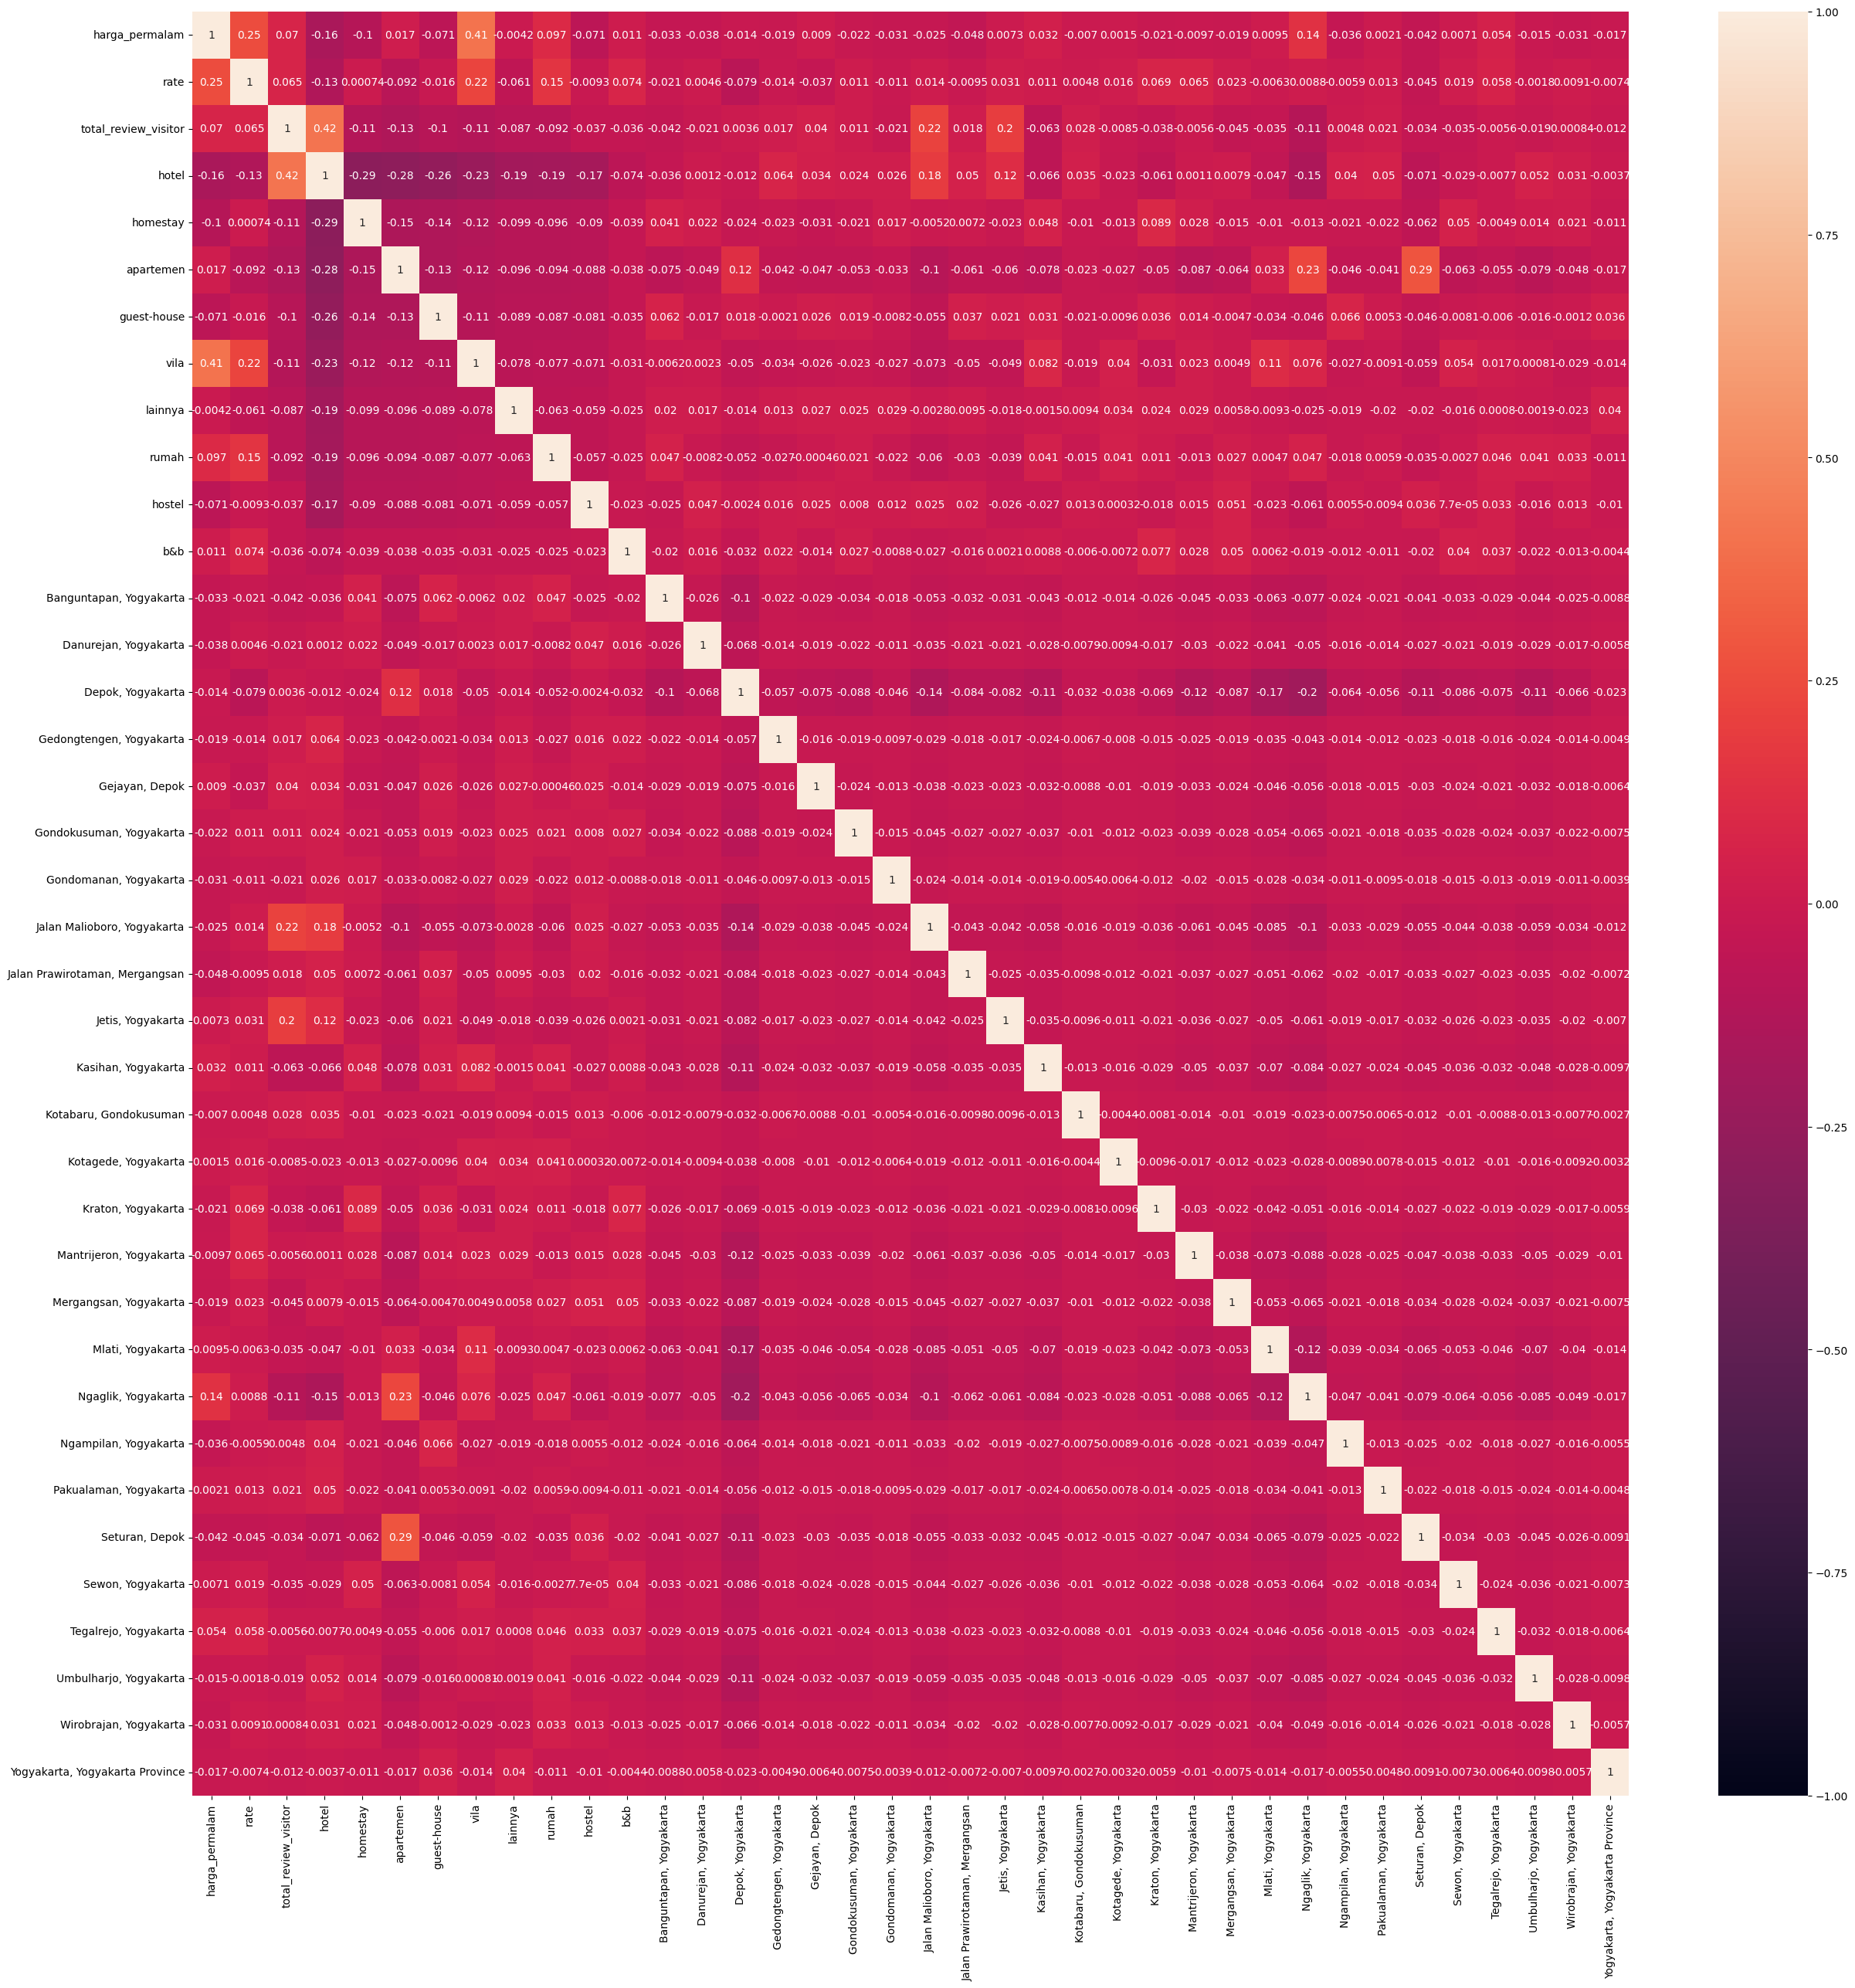

In [ ]:
plt.figure(figsize=(30, 30))
sns.heatmap(data_scraping.corr(), vmin=-1, vmax=1, annot=True)

In [ ]:
data_scraping

,harga_permalam,rate,total_review_visitor,hotel,homestay,apartemen,guest-house,vila,lainnya,rumah,...,"Mlati, Yogyakarta","Ngaglik, Yogyakarta","Ngampilan, Yogyakarta","Pakualaman, Yogyakarta","Seturan, Depok","Sewon, Yogyakarta","Tegalrejo, Yogyakarta","Umbulharjo, Yogyakarta","Wirobrajan, Yogyakarta","Yogyakarta, Yogyakarta Province"
0,514125,8.5,105.0,0,0,1,0,0,0,0,...,False,False,False,False,False,False,False,False,False,False
1,500000,7.9,465.0,1,0,0,0,0,0,0,...,False,False,False,False,False,False,False,False,False,False
2,500000,7.7,52.0,0,0,0,0,0,1,0,...,False,False,False,False,False,False,False,False,False,False
3,500000,8.6,120.0,0,0,0,1,0,0,0,...,False,False,False,False,False,False,False,False,True,False
4,500000,8.1,96.0,0,0,0,0,0,1,0,...,False,False,False,False,False,False,False,True,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11129,1459965,9.4,57.0,0,0,0,0,0,0,0,...,False,False,False,False,False,False,False,False,False,False
11130,1009612,8.8,7740.0,1,0,0,0,0,0,0,...,False,False,False,False,False,False,False,False,False,False
11131,888156,8.8,5499.0,1,0,0,0,0,0,0,...,False,False,False,False,False,False,False,False,False,False
11132,788336,8.6,7549.0,1,0,0,0,0,0,0,...,False,False,False,False,False,False,False,False,False,False


In [ ]:
data_scraping[['harga_permalam', 'total_review_visitor', 'rate']].describe()

,harga_permalam,total_review_visitor,rate
count,1.113400e+04,11134.000000,11134.000000
mean,5.584999e+05,553.201814,8.453503
std,6.979107e+05,1404.528827,0.592560
min,5.040400e+04,5.000000,5.600000
25%,2.247152e+05,23.000000,8.200000
50%,3.928710e+05,61.000000,8.500000
75%,6.155620e+05,223.000000,8.800000
max,9.924090e+06,11453.000000,9.900000


In [ ]:
q_low = data_scraping['harga_permalam'].quantile(0.01)
q_hi  = data_scraping['harga_permalam'].quantile(0.99)

data_scraping = data_scraping[(data_scraping['harga_permalam'] < q_hi) & (data_scraping['harga_permalam'] > q_low)]

In [ ]:
q_low = data_scraping['harga_permalam'].quantile(0.01)
q_hi  = data_scraping['harga_permalam'].quantile(0.99)

data_scraping = data_scraping[(data_scraping['harga_permalam'] < q_hi) & (data_scraping['harga_permalam'] > q_low)]

In [ ]:
data_scraping[['harga_permalam', 'total_review_visitor', 'rate']].describe()

,harga_permalam,total_review_visitor,rate
count,1.068900e+04,10689.000000,10689.000000
mean,4.950046e+05,564.393021,8.452025
std,3.872110e+05,1420.356919,0.586997
min,9.715300e+04,5.000000,5.600000
25%,2.291730e+05,23.000000,8.200000
50%,3.929040e+05,62.000000,8.500000
75%,5.918240e+05,226.000000,8.800000
max,2.475698e+06,11453.000000,9.900000


###Training

In [ ]:
random_state = 0

X = data_scraping.drop(['harga_permalam'],axis = 1)
y = data_scraping['harga_permalam']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

In [ ]:
cv = 6 #number of folds

First method : Linear Regression

In [ ]:
"""model_1 = LinearRegression()
print("R2:")
print(cross_val_score(model_1, X_train.values, y_train.values, cv=cv).mean())
print("MSE:")
print(cross_val_score(model_1, X_train.values, y_train.values, cv=cv, scoring='neg_mean_squared_error').mean())"""

'model_1 = LinearRegression()\nprint("R2:")\nprint(cross_val_score(model_1, X_train.values, y_train.values, cv=cv).mean())\nprint("MSE:")\nprint(cross_val_score(model_1, X_train.values, y_train.values, cv=cv, scoring=\'neg_mean_squared_error\').mean())'

In [ ]:
"""model_1 = model_1.fit(X_train.values, y_train.values)
y_test_pred = model_1.predict(X_test.values)
xmin= min(y_test.min(), y_test_pred.min() )-1
xmax= max(y_test.max(), y_test_pred.max() )+1"""

'model_1 = model_1.fit(X_train.values, y_train.values)\ny_test_pred = model_1.predict(X_test.values)\nxmin= min(y_test.min(), y_test_pred.min() )-1\nxmax= max(y_test.max(), y_test_pred.max() )+1'

In [ ]:
"""fig = plt.figure(1)
plt.scatter(y_test,y_test_pred, marker='+', label='test')
plt.plot([xmin,xmax], [xmin,xmax], lw=3, color='k', ls='--') ## droite separatrice d'equation x2=x1

plt.xlabel('Groundtruth')
plt.ylabel('Prediction')
plt.title('Groundtruth/ Prediction Comparaison')
plt.legend()
plt.savefig('LR.png')"""

"fig = plt.figure(1)\nplt.scatter(y_test,y_test_pred, marker='+', label='test')\nplt.plot([xmin,xmax], [xmin,xmax], lw=3, color='k', ls='--') ## droite separatrice d'equation x2=x1\n\nplt.xlabel('Groundtruth')\nplt.ylabel('Prediction')\nplt.title('Groundtruth/ Prediction Comparaison')\nplt.legend()\nplt.savefig('LR.png')"

###Second method : Random Forest

In [ ]:
model_2 = LinearRegression()
model_2 = RandomForestRegressor(random_state= random_state)
print("R2:")
print(cross_val_score(model_2, X_train.values, y_train.values, cv=cv).mean())
print("MSE:")
print(-cross_val_score(model_2, X_train.values, y_train.values, cv=cv, scoring='neg_mean_squared_error').mean())

R2:
0.9018670228022346
MSE:
14672462524.14071


In [ ]:
model_2 = model_2.fit(X_train.values, y_train.values)
y_test_pred = model_2.predict(X_test.values)
xmin= min(y_test.min(), y_test_pred.min() )-1
xmax= max(y_test.max(), y_test_pred.max() )+1

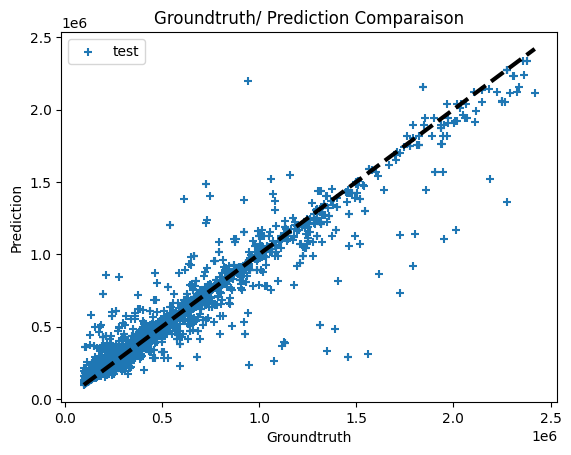

In [ ]:
fig = plt.figure(1)
plt.scatter(y_test,y_test_pred, marker='+', label='test')
plt.plot([xmin,xmax], [xmin,xmax], lw=3, color='k', ls='--') ## droite separatrice d'equation x2=x1

plt.xlabel('Groundtruth')
plt.ylabel('Prediction')
plt.title('Groundtruth/ Prediction Comparaison')
plt.legend()
plt.savefig('RF.png')

###Third Method : Gradient Boosting

In [ ]:
"""model_3 = GradientBoostingRegressor(random_state= random_state)
print("R2:")
print(cross_val_score(model_3, X_train.values, y_train.values, cv=cv).mean())
print("MSE:")
print(-cross_val_score(model_3, X_train.values, y_train.values, cv=cv, scoring='neg_mean_squared_error').mean())"""

'model_3 = GradientBoostingRegressor(random_state= random_state)\nprint("R2:")\nprint(cross_val_score(model_3, X_train.values, y_train.values, cv=cv).mean())\nprint("MSE:")\nprint(-cross_val_score(model_3, X_train.values, y_train.values, cv=cv, scoring=\'neg_mean_squared_error\').mean())'

In [ ]:
"""model_3 = model_3.fit(X_train.values, y_train.values)
y_test_pred = model_3.predict(X_test.values)
xmin= min(y_test.min(), y_test_pred.min() )-1
xmax= max(y_test.max(), y_test_pred.max() )+1"""

'model_3 = model_3.fit(X_train.values, y_train.values)\ny_test_pred = model_3.predict(X_test.values)\nxmin= min(y_test.min(), y_test_pred.min() )-1\nxmax= max(y_test.max(), y_test_pred.max() )+1'

In [ ]:
"""fig = plt.figure(1)
plt.scatter(y_test,y_test_pred, marker='+', label='test')
plt.plot([xmin,xmax], [xmin,xmax], lw=3, color='k', ls='--') ## droite separatrice d'equation x2=x1

plt.xlabel('Groundtruth')
plt.ylabel('Prediction')
plt.title('Groundtruth/ Prediction Comparaison')
plt.legend()
plt.savefig('XGB.png')"""

"fig = plt.figure(1)\nplt.scatter(y_test,y_test_pred, marker='+', label='test')\nplt.plot([xmin,xmax], [xmin,xmax], lw=3, color='k', ls='--') ## droite separatrice d'equation x2=x1\n\nplt.xlabel('Groundtruth')\nplt.ylabel('Prediction')\nplt.title('Groundtruth/ Prediction Comparaison')\nplt.legend()\nplt.savefig('XGB.png')"

###Hyperparameters Optimization

In [ ]:
# Create the parameter grid based on the results of random search
param_grid = {
    'n_estimators': [100, 150, 200, 400, 500]
}
# Create a based model
rf = RandomForestRegressor(random_state= random_state)
# Instantiate the grid search model
grid_search = GridSearchCV(estimator = rf, param_grid = param_grid,
                          cv = cv, n_jobs = -1, verbose = 2)

In [ ]:
grid_search.fit(X_train.values, y_train.values)
best_grid = grid_search.best_estimator_

Fitting 6 folds for each of 5 candidates, totalling 30 fits


In [ ]:
print("R2:")
print(cross_val_score(best_grid, X_train.values, y_train.values, cv=cv).mean())
print("MSE:")
print(-cross_val_score(best_grid, X_train.values, y_train.values, cv=cv, scoring='neg_mean_squared_error').mean())

R2:
0.902984017286192
MSE:
14503929715.145378


In [ ]:
grid_search.best_params_

{'n_estimators': 100}

In [ ]:
from sklearn.model_selection import GridSearchCV
# Create the parameter grid based on the results of random search
param_grid = {

    'n_estimators': [10, 20, 30, 50, 70, 100]
}
# Create a based model
rf = GradientBoostingRegressor(random_state= random_state)
# Instantiate the grid search model
grid_search = GridSearchCV(estimator = rf, param_grid = param_grid,
                          cv = cv, n_jobs = -1, verbose = 2)

In [ ]:
grid_search.fit(X_train.values, y_train.values)
best_grid = grid_search.best_estimator_

Fitting 6 folds for each of 6 candidates, totalling 36 fits


In [ ]:
print("R2:")
print(cross_val_score(best_grid, X_train.values, y_train.values, cv=cv).mean())
print("MSE:")
print(-cross_val_score(best_grid, X_train.values, y_train.values, cv=cv, scoring='neg_mean_squared_error').mean())

R2:
0.6181736558029797
MSE:
57041631029.00065


In [ ]:
grid_search.best_params_

{'n_estimators': 100}

In [ ]:
plt.figure(figsize=(8, 5))
sns.histplot(data_scraping['harga_permalam'], bins=30, kde=True)
plt.title('Distribusi Harga per Malam')
plt.xlabel('Harga per Malam')
plt.ylabel('Jumlah')
plt.tight_layout()
plt.show()

NameError: name 'plt' is not defined

In [ ]:
"""plt.figure(figsize=(10, 6))
sns.boxplot(x='type_hotal', y='harga_permalam', data=data_scraping)
plt.title('Perbandingan Harga per Malam Berdasarkan Tipe Akomodasi')
plt.xlabel('Tipe Akomodasi')
plt.ylabel('Harga per Malam')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()"""

"plt.figure(figsize=(10, 6))\nsns.boxplot(x='type_hotal', y='harga_permalam', data=data_scraping)\nplt.title('Perbandingan Harga per Malam Berdasarkan Tipe Akomodasi')\nplt.xlabel('Tipe Akomodasi')\nplt.ylabel('Harga per Malam')\nplt.xticks(rotation=45)\nplt.tight_layout()\nplt.show()"

In [ ]:
"""plt.figure(figsize=(10, 5))
sns.countplot(x='type_hotal', hue='periode', data=data_scraping)
plt.title('Jumlah Tipe Akomodasi per Periode')
plt.xlabel('Tipe Akomodasi')
plt.ylabel('Jumlah')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()"""


"plt.figure(figsize=(10, 5))\nsns.countplot(x='type_hotal', hue='periode', data=data_scraping)\nplt.title('Jumlah Tipe Akomodasi per Periode')\nplt.xlabel('Tipe Akomodasi')\nplt.ylabel('Jumlah')\nplt.xticks(rotation=45)\nplt.tight_layout()\nplt.show()"

In [ ]:
"""plt.figure(figsize=(6, 4))
sns.barplot(x='periode', y='harga_permalam', data=data_scraping, estimator=np.mean)
plt.title('Rata-rata Harga per Malam Berdasarkan Periode')
plt.ylabel('Rata-rata Harga')
plt.xlabel('Periode')
plt.tight_layout()
plt.show()"""


"plt.figure(figsize=(6, 4))\nsns.barplot(x='periode', y='harga_permalam', data=data_scraping, estimator=np.mean)\nplt.title('Rata-rata Harga per Malam Berdasarkan Periode')\nplt.ylabel('Rata-rata Harga')\nplt.xlabel('Periode')\nplt.tight_layout()\nplt.show()"